In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy import stats

Simulate some data, embed it and calculate the *true* value of the test statistic. This will be the same for any permutationss or iterations, so is calculated outside of the loops and is stored.

In [72]:
# Set a random seed for reproducibility
np.random.seed(6)

p_values_iter = []
# Parameters
n = 100  # Number of permutations
d = 2  # Number of dimensions
T = 4

# MANY ITERATIONS TO GET MANY P-VALUES BACK
for iter in range(1000):
    # A = abs(np.random.normal(0, 1, (n, n*T)))
    A = np.round(abs(np.random.standard_t(df=1.2, size=(n, n*T))), decimals=0)
    u, s, vt = np.linalg.svd(A, full_matrices=True)  # number of singular values and vectors to compute

    s_idx = np.argsort(s)[::-1][0:d]
    ya = vt.T[:, s_idx] @ np.diag(np.sqrt(s[s_idx]))

    # label nodes - 1=earlyC1, 2=earlyC2, 3=lateC1, 4=lateC2
    label = np.repeat(1, n*T/4)
    for i in range(2, 5):
        label = np.hstack((label, np.repeat(i, n*T/4)))

    # # Calculate a test statistic based on the "true observation"
    earlydiff = np.mean(ya[0:int(n*T/4), :], axis=0) - np.mean(ya[int(n*T/4):int(2*n*T/4), :], axis=0) # between earlyC1 and earlyC2
    latediff = np.mean(ya[int(2*n*T/4):int(3*n*T/4), :], axis=0) - np.mean(ya[int(3*n*T/4):int(4*n*T/4), :], axis=0) # between lateC1 and lateC2
    true_stat = earlydiff - latediff # this is a d-dimensional vector


    shuff_perm_stats = []
    pvalues = []

    for p in range(100): # number of permuations
        # so now each row still has the same node in it, but they are shuffled around as if time doesn't matter 
        shuffya = ya # np.zeros((n*T, d)) # intialise

        for node in range(n):# randomly assign each node indep as early/late
            # find a way to pick out 2 of each node's observations 
            order = np.random.permutation([0,1,2,3])
            node_embeddings = ya[[node, (n+node), ((2*n)+node), ((3*n)+node)],:]
            shuffya[node,:] = node_embeddings[order[0],:]
            shuffya[n+node,:] = node_embeddings[order[1],:]
            shuffya[(2*n)+node,:] = node_embeddings[order[2],:]
            shuffya[(3*n)+node,:] = node_embeddings[order[3],:]

        # THINK ABOUT WHAT IS C1 AND C2 AND EARLY AND LATE AND FIGURE OUT HOW TO SPLIT UP THE SHUFFLED 4 PARTITIONS AND THEN CALCULATE THE TEST STATISTIC
        shuffearlydiff = np.mean(shuffya[0:int(n*T/4), :], axis=0) - np.mean(shuffya[int(n*T/4):int(2*n*T/4), :], axis=0) # between "early"C1 and "early"C2
        shufflatediff = np.mean(shuffya[int(2*n*T/4):int(3*n*T/4), :], axis=0) - np.mean(shuffya[int(3*n*T/4):int(4*n*T/4), :], axis=0) # between "late"C1 and "late"C2
        shuff_perm_stat = shuffearlydiff - shufflatediff # this is a d-dimensional vector

        #add it to the list of perm stats
        shuff_perm_stats.append(shuff_perm_stat)

    # Add the true stat to the list of permutation stats, as need it to calculate p-value
    shuff_perm_stats.append(true_stat)

    # calculate the d p-values
    p_values = []
    for dim in range(d):
        perm_stats_dim = []
        for i in range(len(shuff_perm_stats)):
            perm_stats_dim.append(shuff_perm_stats[i][dim])
        p_value = (np.sum(perm_stats_dim >= true_stat[dim]) + np.sum(perm_stats_dim <= -true_stat[dim])) / (2*(n+1))
        p_values.append(p_value)

    p_values_iter.append(p_values)

In [73]:
# extract the p-values for each dimension
dim1_pvalues = [sublist[0] for sublist in p_values_iter]
dim2_pvalues = [sublist[1] for sublist in p_values_iter]

(array([63., 47., 39., 53., 36., 47., 45., 51., 57., 57., 43., 46., 47.,
        57., 56., 49., 48., 54., 45., 60.]),
 array([0.0049505 , 0.05470297, 0.10445545, 0.15420792, 0.2039604 ,
        0.25371287, 0.30346535, 0.35321782, 0.4029703 , 0.45272277,
        0.50247525, 0.55222772, 0.6019802 , 0.65173267, 0.70148515,
        0.75123762, 0.8009901 , 0.85074257, 0.90049505, 0.95024752,
        1.        ]),
 <BarContainer object of 20 artists>)

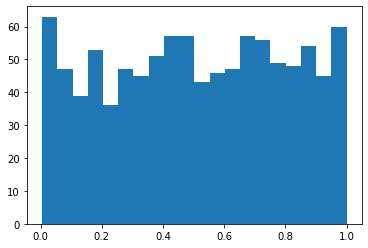

In [74]:
plt.hist(dim1_pvalues, bins=20)

(array([56., 47., 55., 61., 39., 60., 57., 41., 50., 42., 52., 49., 63.,
        42., 50., 45., 46., 52., 35., 58.]),
 array([0.0049505 , 0.05470297, 0.10445545, 0.15420792, 0.2039604 ,
        0.25371287, 0.30346535, 0.35321782, 0.4029703 , 0.45272277,
        0.50247525, 0.55222772, 0.6019802 , 0.65173267, 0.70148515,
        0.75123762, 0.8009901 , 0.85074257, 0.90049505, 0.95024752,
        1.        ]),
 <BarContainer object of 20 artists>)

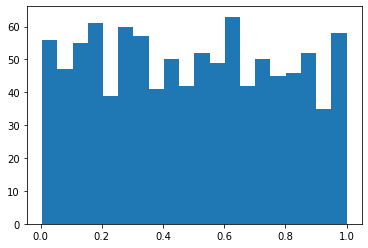

In [75]:
plt.hist(dim2_pvalues, bins=20)

Transform A with a log and Wins and see if this affects the p-values

In [76]:
# log and winsorize
Atransformed = np.log10(A+1)
Atransformed = winsorize(Atransformed, limits = [0, 0.01])

In [77]:
# Set a random seed for reproducibility
np.random.seed(6)

p_values_iter = []
# Parameters
n = 100  # Number of permutations
d = 2  # Number of dimensions
T = 4

# MANY ITERATIONS TO GET MANY P-VALUES BACK
for iter in range(1000):
    # A = abs(np.random.normal(0, 1, (n, n*T)))
    A = np.round(abs(np.random.standard_t(df=1.2, size=(n, n*T))), decimals=0)
    # log and winsorize
    A = np.log10(A+1)
    A = winsorize(A, limits = [0, 0.01])
    u, s, vt = np.linalg.svd(A, full_matrices=True)  # number of singular values and vectors to compute

    s_idx = np.argsort(s)[::-1][0:d]
    ya = vt.T[:, s_idx].dot(np.diag(np.sqrt(s[s_idx])))

    # label nodes - 1=earlyC1, 2=earlyC2, 3=lateC1, 4=lateC2
    label = np.repeat(1, n*T/4)
    for i in range(2, 5):
        label = np.hstack((label, np.repeat(i, n*T/4)))

    # # Calculate a test statistic based on the "true observation"
    earlydiff = np.mean(ya[0:int(n*T/4), :], axis=0) - np.mean(ya[int(n*T/4):int(2*n*T/4), :], axis=0) # between earlyC1 and earlyC2
    latediff = np.mean(ya[int(2*n*T/4):int(3*n*T/4), :], axis=0) - np.mean(ya[int(3*n*T/4):int(4*n*T/4), :], axis=0) # between lateC1 and lateC2
    true_stat = earlydiff - latediff # this is a d-dimensional vector


    shuff_perm_stats = []
    pvalues = []

    for p in range(100): # number of permuations
        # so now each row still has the same node in it, but they are shuffled around as if time doesn't matter 
        shuffya = ya # np.zeros((n*T, d)) # intialise

        for node in range(n):# randomly assign each node indep as early/late
            # find a way to pick out 2 of each node's observations 
            order = np.random.permutation([0,1,2,3])
            node_embeddings = ya[[node, (n+node), ((2*n)+node), ((3*n)+node)],:]
            shuffya[node,:] = node_embeddings[order[0],:]
            shuffya[n+node,:] = node_embeddings[order[1],:]
            shuffya[(2*n)+node,:] = node_embeddings[order[2],:]
            shuffya[(3*n)+node,:] = node_embeddings[order[3],:]

        # THINK ABOUT WHAT IS C1 AND C2 AND EARLY AND LATE AND FIGURE OUT HOW TO SPLIT UP THE SHUFFLED 4 PARTITIONS AND THEN CALCULATE THE TEST STATISTIC
        shuffearlydiff = np.mean(shuffya[0:int(n*T/4), :], axis=0) - np.mean(shuffya[int(n*T/4):int(2*n*T/4), :], axis=0) # between "early"C1 and "early"C2
        shufflatediff = np.mean(shuffya[int(2*n*T/4):int(3*n*T/4), :], axis=0) - np.mean(shuffya[int(3*n*T/4):int(4*n*T/4), :], axis=0) # between "late"C1 and "late"C2
        shuff_perm_stat = shuffearlydiff - shufflatediff # this is a d-dimensional vector

        #add it to the list of perm stats
        shuff_perm_stats.append(shuff_perm_stat)

    # Add the true stat to the list of permutation stats, as need it to calculate p-value
    shuff_perm_stats.append(true_stat)

    # calculate the d p-values
    p_values = []
    for dim in range(d):
        perm_stats_dim = []
        for i in range(len(shuff_perm_stats)):
            perm_stats_dim.append(shuff_perm_stats[i][dim])
        p_value = (np.sum(perm_stats_dim >= true_stat[dim]) + np.sum(perm_stats_dim <= -true_stat[dim])) / (2*(n+1))
        p_values.append(p_value)

    p_values_iter.append(p_values)

In [78]:
# extract the p-values for each dimension
dim1_pvalues_transformed = [sublist[0] for sublist in p_values_iter]
dim2_pvalues_transformed = [sublist[1] for sublist in p_values_iter]

(array([53., 42., 45., 66., 55., 41., 48., 47., 47., 59., 54., 46., 51.,
        53., 54., 45., 46., 52., 53., 43.]),
 array([0.0049505 , 0.05470297, 0.10445545, 0.15420792, 0.2039604 ,
        0.25371287, 0.30346535, 0.35321782, 0.4029703 , 0.45272277,
        0.50247525, 0.55222772, 0.6019802 , 0.65173267, 0.70148515,
        0.75123762, 0.8009901 , 0.85074257, 0.90049505, 0.95024752,
        1.        ]),
 <BarContainer object of 20 artists>)

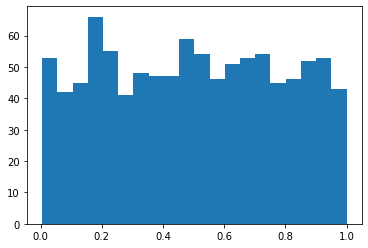

In [79]:
plt.hist(dim1_pvalues_transformed, bins=20)

(array([45., 49., 61., 50., 56., 48., 51., 49., 40., 57., 58., 43., 48.,
        49., 39., 54., 46., 43., 54., 60.]),
 array([0.0049505 , 0.05470297, 0.10445545, 0.15420792, 0.2039604 ,
        0.25371287, 0.30346535, 0.35321782, 0.4029703 , 0.45272277,
        0.50247525, 0.55222772, 0.6019802 , 0.65173267, 0.70148515,
        0.75123762, 0.8009901 , 0.85074257, 0.90049505, 0.95024752,
        1.        ]),
 <BarContainer object of 20 artists>)

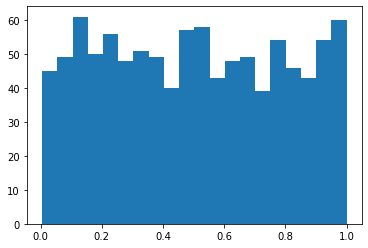

In [80]:
plt.hist(dim2_pvalues_transformed, bins=20)

In [81]:
stats.kstest(dim2_pvalues,
             stats.uniform.cdf)

KstestResult(statistic=0.025415841584158383, pvalue=0.5296851230823691)

In [82]:
stats.kstest(dim2_pvalues_transformed,
             stats.uniform.cdf)

KstestResult(statistic=0.017178217821782193, pvalue=0.9244388516637689)

In [83]:
stats.kstest(dim1_pvalues,
             stats.uniform.cdf)

KstestResult(statistic=0.028287128712871257, pvalue=0.3930802553494678)

In [84]:
stats.kstest(dim1_pvalues_transformed,
             stats.uniform.cdf)

KstestResult(statistic=0.019712871287128717, pvalue=0.8243812568239157)